# [WIP] Coin Tossing 2.0

## An analysis on the impact of p-hacking when performing A/B tests

This is an update of the simulation created [here](https://github.com/fsalhani/coin_tossing/blob/master/Coin%20tossing%20simulation.ipynb)

In [1]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

First, I'll create some variables to simplify the code later

In [2]:
HEADS = 1
TAILS = 0
COIN_TYPES = ['PENNY', 'NICKEL', 'DIME', 'QUARTER', 'HALF-DOLLAR', 'DOLLAR']
NUMBER_OF_SAMPLES = 10000
NUMBER_OF_TESTS = 1000
DEFAULT_P_VALUE = 0.05

In [3]:
index = pd.MultiIndex(
            levels=[list(range(NUMBER_OF_TESTS)),['coin1_result','coin1_type','coin2_result','coin2_type','p_value']],
            codes=[sorted(list(range(NUMBER_OF_TESTS))*5),[0,1,2,3,4]*NUMBER_OF_TESTS],
            names=['Iteration','info']
                     )
base_df = pd.DataFrame('0', index=index, columns=range(NUMBER_OF_SAMPLES))

This is a very simple `coin_toss` method

In [4]:
def coin_toss():
    return random.choice([HEADS,TAILS])

###### CREATING THE DATA SET

Now let's create the data set. It has 1,000 experiments. For each, it performs 10,000 tosses at random, also choosing the coin types randomly

In [11]:
for j in range(NUMBER_OF_TESTS):
    coin_1 = []
    coin_2 = []
    p_values = []
    for i in range(NUMBER_OF_SAMPLES):
        base_df.loc[j,'coin1_type'].loc[i] = random.choice(COIN_TYPES)
        base_df.loc[j,'coin2_type'].loc[i] = random.choice(COIN_TYPES)
        coin_1.append(coin_toss())
        coin_2.append(coin_toss())
        _,p_value = stats.ttest_ind(coin_1,coin_2)
        p_values.append(p_value)
        p_values[0] = 1
    base_df.loc[j,'coin1_result'] = coin_1
    base_df.loc[j,'coin2_result'] = coin_2
    base_df.loc[j,'p_value'] = p_values

I'll save the data set to csv just so that I don't have to keep the kernel up all the time

In [13]:
base_df.to_csv('coin_tosses.csv')

**If restarting a kernel**, don't run the entire simulation. **START FROM HERE**

In [3]:
base_df = pd.read_csv('coin_tosses.csv')

In [4]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 10002 entries, Iteration to 9999
dtypes: int64(1), object(10001)
memory usage: 381.5+ MB


In [5]:
col_copy = base_df.columns.copy().tolist()
col_copy[1] = 'info'
base_df.columns = col_copy

In [6]:
base_df = base_df.set_index(['Iteration','info'])
base_df.columns = pd.Series(col_copy[2:]).apply(int).tolist()

In [7]:
base_df.head()

0                    1            2     \
Iteration info                                                          
0         coin1_result            1                    0            1   
          coin1_type    HALF-DOLLAR               NICKEL       DOLLAR   
          coin2_result            1                    1            0   
          coin2_type    HALF-DOLLAR          HALF-DOLLAR  HALF-DOLLAR   
          p_value                 1  0.42264973081037427          1.0   

                                      3                   4     \
Iteration info                                                   
0         coin1_result                   1                   0   
          coin1_type                  DIME              DOLLAR   
          coin2_result                   0                   0   
          coin2_type           HALF-DOLLAR              DOLLAR   
          p_value       0.5369633243867579  0.5795840000000001   

                                     5                   6     \
Iteration info                                                  
0         coin1_result                  0                   1   
          coin1_type                 DIME              DOLLAR   
          coin2_result                  0                   0   
          coin2_type                PENNY         HALF-DOLLAR   
          p_value       0.599470310654575  0.3168543569775698   

                                      7                    8     \
Iteration info                                                    
0         coin1_result                   1                    0   
          coin1_type                 PENNY               DOLLAR   
          coin2_result                   0                    0   
          coin2_type                  DIME               DOLLAR   
          p_value       0.1489038747445396  0.16494927617311392   

                                      9     ...                 9990  \
Iteration info                              ...                        
0         coin1_result                   0  ...                    1   
          coin1_type                DOLLAR  ...              QUARTER   
          coin2_result                   0  ...                    0   
          coin2_type           HALF-DOLLAR  ...               NICKEL   
          p_value       0.1768796480794004  ...  0.43648962413768666   

                                       9991                9992  \
Iteration info                                                    
0         coin1_result                    0                   1   
          coin1_type                 DOLLAR               PENNY   
          coin2_result                    1                   0   
          coin2_type                QUARTER               PENNY   
          p_value       0.42821891240886034  0.4365355263001097   

                                      9993               9994  \
Iteration info                                                  
0         coin1_result                   0                  0   
          coin1_type                NICKEL             DOLLAR   
          coin2_result                   1                  1   
          coin2_type                DOLLAR             DOLLAR   
          p_value       0.4282651274491972  0.420087440935903   

                                       9995                 9996  \
Iteration info                                                     
0         coin1_result                    1                    0   
          coin1_type            HALF-DOLLAR               NICKEL   
          coin2_result                    0                    1   
          coin2_type                 NICKEL              QUARTER   
          p_value       0.42831133151958356  0.42013393601362004   

                                      9997                9998  \
Iteration info                                                   
0         coin1_result                   0                   0   
          coin1_type    

## Correctly analyzing the data

* How many false positives do we have? (How many times was the p-value for the experiments lower than 5%?)

To answer that using proper methods, I will just look at the final result of each experiment

In [8]:
final_p_values = np.array(base_df.droplevel(0).loc['p_value'][NUMBER_OF_SAMPLES-1]).astype('float')
false_positive_rate = sum(final_p_values <= DEFAULT_P_VALUE)/len(final_p_values)

print(f'The p-value at the end of the experiment was lower than {DEFAULT_P_VALUE} for {round(false_positive_rate*100,1)}% of the experiments')

The p-value at the end of the experiment was lower than 0.05 for 4.4% of the experiments


## P-Hacking our data

* What happens if I try to check my p-value many times during the test?
* What if I check all different coin types?

In [9]:
mid_p_values = np.array(base_df.droplevel(0).loc['p_value'][NUMBER_OF_SAMPLES/2-1]).astype('float')
false_positive_rate = sum((final_p_values <= DEFAULT_P_VALUE) | (mid_p_values <= DEFAULT_P_VALUE))/len(final_p_values)

print(f'Also checking the p-value in the middle of the experiment we find p-values lower than {DEFAULT_P_VALUE} for {round(false_positive_rate*100,1)}% of the experiments')

Also checking the p-value in the middle of the experiment we find p-values lower than 0.05 for 8.1% of the experiments


In [10]:
third_1 = np.array(base_df.droplevel(0).loc['p_value'][NUMBER_OF_SAMPLES//3 - 1]).astype('float')
third_2 = np.array(base_df.droplevel(0).loc['p_value'][NUMBER_OF_SAMPLES//3*2 - 1]).astype('float')
false_positive_rate = sum((final_p_values <= DEFAULT_P_VALUE) | (third_1 <= DEFAULT_P_VALUE) | (third_2 <= DEFAULT_P_VALUE))/len(final_p_values)

print(f'Checking the p-value 3 times during the experiment we find p-values lower than {DEFAULT_P_VALUE} for {round(false_positive_rate*100,1)}% of the experiments')

Checking the p-value 3 times during the experiment we find p-values lower than 0.05 for 9.7% of the experiments


**How does that progress?**

In [13]:
false_positives = []
false_positives_to_df = []
tests = list(range(1,10)) + list(np.array(range(1,10))*10) + list(np.array(range(1,10))*100) + list(np.array(range(1,10))*1000) + [10000]

for i in tests:
    list_indexes = ((10000/i) * np.array(range(1,i+1)) - 1).astype(int)
    false_positives.append((sum(sum((np.array(base_df.droplevel(0).loc['p_value'][list_indexes]).astype('float') < 0.05).T)>=1)/10))
    false_positives_to_df.append(str(round(sum(sum((np.array(base_df.droplevel(0).loc['p_value'][list_indexes]).astype('float') < 0.05).T)>=1)/10,1))+'%')

fp_rate_df = pd.DataFrame([tests,false_positives_to_df], index=['number_of_observations','false_positive_rate']).transpose().set_index('number_of_observations')
fp_rate_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


,false_positive_rate
number_of_observations,
1,4.4%
2,8.1%
3,9.7%
4,11.3%
5,13.8%
6,14.5%
7,15.9%
8,16.7%
9,16.9%


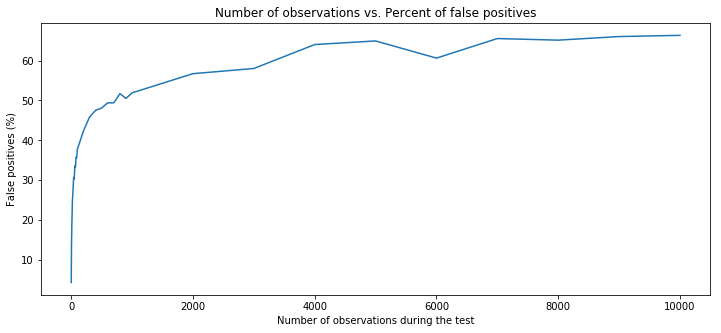

In [20]:
plt.figure(figsize=[12,5])
plt.plot(tests,np.array(false_positives))
plt.xlabel('Number of observations during the test')
plt.ylabel('False positives (%)')
plt.title('Number of observations vs. Percent of false positives')
plt.show()

**Checking each coin type**

In [15]:
results = []

for coin_type in COIN_TYPES:
    print(coin_type)
    total1 = sum((np.array(base_df.droplevel(0).loc['coin1_type'] == coin_type).T))
    trues1 = sum((np.array(base_df.droplevel(0).loc['coin1_type'] == coin_type) & np.array(base_df.droplevel(0).loc['coin1_result'].applymap(int).applymap(bool))).T)
    falses1 = total1 - trues1
    total2 = sum((np.array(base_df.droplevel(0).loc['coin2_type'] == coin_type).T))
    trues2 = sum((np.array(base_df.droplevel(0).loc['coin2_type'] == coin_type) & np.array(base_df.droplevel(0).loc['coin2_result'].applymap(int).applymap(bool))).T)
    falses2 = total2 - trues2
    values = []
    for i in range(len(total1)):
        arr1 = np.append(np.zeros(falses1[i]), np.ones(trues1[i]))
        arr2 = np.append(np.zeros(falses2[i]), np.ones(trues2[i]))
        _,p_value = stats.ttest_ind(arr1,arr2)
        values.append(p_value)
    results.append(values)

PENNY
NICKEL
DIME
QUARTER
HALF-DOLLAR
DOLLAR


In [16]:
type_false_positives = sum(sum(np.array(results) < 0.05)>0)

print(f'If we check the results for each coin type, {type_false_positives} out of {NUMBER_OF_TESTS} experiments would find at least one "significant" difference')

If we check the results for each coin type, 282 out of 1000 experiments would find at least one "significant" difference


## Sequential analysis

Applying 3 different sequential analysis to see how they affect the final result

**O'Brien-Fleming**

In [17]:
t1 = np.array(base_df.droplevel(0).loc['p_value'][1999]).astype('float') < 0.000005
t2 = np.array(base_df.droplevel(0).loc['p_value'][3999]).astype('float') < 0.0013
t3 = np.array(base_df.droplevel(0).loc['p_value'][5999]).astype('float') < 0.0085
t4 = np.array(base_df.droplevel(0).loc['p_value'][7999]).astype('float') < 0.0228
t5 = np.array(base_df.droplevel(0).loc['p_value'][9999]).astype('float') < 0.0417

fp = sum(t1 | t2 | t3 | t4 | t5)

print(f'Applying the O\'Brien-Fleming method, we would get false positives for {fp} out of 1,000 experiments')

Applying the O'Brien-Fleming method, we would get false positives for 42 out of 1,000 experiments


**Pocock**

In [18]:
t1 = np.array(base_df.droplevel(0).loc['p_value'][1999]).astype('float') < 0.0158
t2 = np.array(base_df.droplevel(0).loc['p_value'][3999]).astype('float') < 0.0158
t3 = np.array(base_df.droplevel(0).loc['p_value'][5999]).astype('float') < 0.0158
t4 = np.array(base_df.droplevel(0).loc['p_value'][7999]).astype('float') < 0.0158
t5 = np.array(base_df.droplevel(0).loc['p_value'][9999]).astype('float') < 0.0158

fp = sum(t1 | t2 | t3 | t4 | t5)

print(f'Applying the Pocock method, we would get false positives for {fp} out of 1,000 experiments')

Applying the O'Brien-Fleming method, we would get false positives for 41 out of 1,000 experiments


**Haybittle-Peto**

In [19]:
t1 = np.array(base_df.droplevel(0).loc['p_value'][1999]).astype('float') < 0.001
t2 = np.array(base_df.droplevel(0).loc['p_value'][3999]).astype('float') < 0.001
t3 = np.array(base_df.droplevel(0).loc['p_value'][5999]).astype('float') < 0.001
t4 = np.array(base_df.droplevel(0).loc['p_value'][7999]).astype('float') < 0.001
t5 = np.array(base_df.droplevel(0).loc['p_value'][9999]).astype('float') < 0.05

fp = sum(t1 | t2 | t3 | t4 | t5)

print(f'Applying the Haybittle-Peto method, we would get false positives for {fp} out of 1,000 experiments')

Applying the Haybittle-Peto method, we would get false positives for 45 out of 1,000 experiments
